### <font color="black" size='3'><b>Grupo em ordem alfabética  </b></font>
<html>
<table border="1px">
<tr>
<td bgcolor="Aquamarine">Nome do Aluno</td>
<td bgcolor="Aquamarine">RA</td>
</tr>
<tr>
<td bgcolor="white">Alcir Canella Filho</td>
<td bgcolor="white">10396389</td>
</tr>
<tr>
<td bgcolor="white">Felipe Clé Monteiro</td>
<td bgcolor="white">10395521</td>
</tr>
    <tr>
<td bgcolor="white">Matheus Marques</td>
<td bgcolor="white">10395894</td>
</tr>
    </table>
</html>

# **Bibliotecas e Instalações**

In [3]:
%%capture 

!pip install shap
!pip install optuna
!pip install xgboost
!pip install lightgbm

In [4]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '10'  # Qtde de núcleos da CPU

In [5]:
seed = 10 # semente para o random_state
# Básicas
import pandas as pd
import numpy as np
import plotly.express as px

# Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#Otimização Hiperparametros
import optuna
from optuna.samplers import RandomSampler
from optuna.visualization import plot_optimization_history

In [6]:
import sklearn
import xgboost
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', sklearn.__version__)
print('optuna:', optuna.__version__)
print('xgboost:', xgboost.__version__)

pandas: 2.2.2
numpy: 1.26.4
sklearn: 1.5.1
optuna: 4.2.1
xgboost: 2.1.4


In [7]:
#Arquivo separado com algumas funções mais complexas, para deixar este notebook mais organizado
from functions import *

# **Introdução**

**Ideia Geral**

Utilizando os dados de câncer da FOSP, selecionados para Câncer de Prostata, serão utilizados três modelos de machine learning diferentes, com o intuito de testar diferentes tipos de algoritmo na classificação de sobrevida.

> O label é 0 se o paciente não sobreviveu após cinco anos do diagnóstico e 1 se sobreviveu.

In [9]:
df= pd.read_csv('data_preProcess2.csv', sep = ',', encoding = 'UTF-8',low_memory=False)

In [10]:
df.shape

(56874, 32)

In [11]:
# Valores faltantes
df.isna().sum().sort_values(ascending=False).head(6)

IDADE           0
IBGE            0
vivo_ano3       0
vivo_ano1       0
obito_cancer    0
obito_geral     0
dtype: int64

In [12]:
# Correlação com a saída
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['obito_cancer']).sort_values(ascending = False).head(20)

obito_cancer    1.000000
obito_geral     0.572756
QUIMIO          0.301402
HORMONIO        0.272434
ULTINFO         0.267557
RECNENHUM       0.216166
ANODIAG         0.174348
ULTIDIAG        0.168236
vivo_ano3       0.166054
ULTICONS        0.165836
ULTITRAT        0.160256
vivo_ano5       0.160162
CIRURGIA        0.147641
CATEATEND       0.140138
IDADE           0.124750
vivo_ano1       0.091717
IBGEATEN        0.087014
DIAGPREV        0.085036
OUTROS          0.061452
RRAS            0.055287
Name: obito_cancer, dtype: float64

In [13]:
#Dados com valores categoricos.
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
print(non_numeric_cols)


Index(['EC', 'TRATHOSP'], dtype='object')


In [14]:
# Quantidade de pacientes em cada classe da saída
df.obito_cancer.value_counts()

obito_cancer
0    49204
1     7670
Name: count, dtype: int64

## **DataFrame Obito por Câncer**


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56874 entries, 0 to 56873
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IDADE         56874 non-null  int64 
 1   IBGE          56874 non-null  int64 
 2   CATEATEND     56874 non-null  int64 
 3   DIAGPREV      56874 non-null  int64 
 4   EC            56874 non-null  object
 5   TRATHOSP      56874 non-null  object
 6   NENHUM        56874 non-null  int64 
 7   CIRURGIA      56874 non-null  int64 
 8   RADIO         56874 non-null  int64 
 9   QUIMIO        56874 non-null  int64 
 10  HORMONIO      56874 non-null  int64 
 11  TMO           56874 non-null  int64 
 12  IMUNO         56874 non-null  int64 
 13  OUTROS        56874 non-null  int64 
 14  NENHUMANT     56874 non-null  int64 
 15  ULTINFO       56874 non-null  int64 
 16  CONSDIAG      56874 non-null  int64 
 17  TRATCONS      56874 non-null  int64 
 18  DIAGTRAT      56874 non-null  int64 
 19  ANOD

In [17]:
list_drop = ['ULTICONS', 'ULTIDIAG', 'ULTITRAT',  'vivo_ano1',
             'vivo_ano3', 'vivo_ano5',  'ULTINFO', 'obito_geral']

lb = 'obito_cancer'

In [18]:
X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df, list_drop, lb, 
                                                                       random_state=seed,
                                                                       balance_data=True,
                                                                       encoder_type='LabelEncoder', 
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True)

X_train = (73806, 23), X_test = (14219, 23)
y_train = (73806,), y_test = (14219,)


In [19]:
y_train.value_counts(normalize=True)

obito_cancer
0    0.5
1    0.5
Name: proportion, dtype: float64

In [20]:
y_test.value_counts(normalize=True)

obito_cancer
0    0.86511
1    0.13489
Name: proportion, dtype: float64

# Naive Bayes


In [22]:
# Criação e treinamento do modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

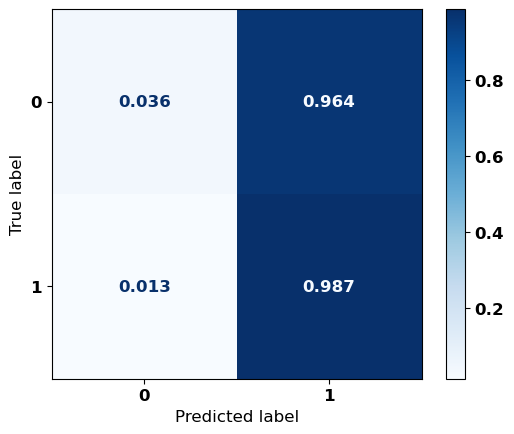


              precision    recall  f1-score   support

           0      0.948     0.036     0.068     12301
           1      0.138     0.987     0.242      1918

    accuracy                          0.164     14219
   macro avg      0.543     0.512     0.155     14219
weighted avg      0.839     0.164     0.092     14219



In [23]:
# Matriz de confusão
plot_confusion_matrix(nb, X_test, y_test)

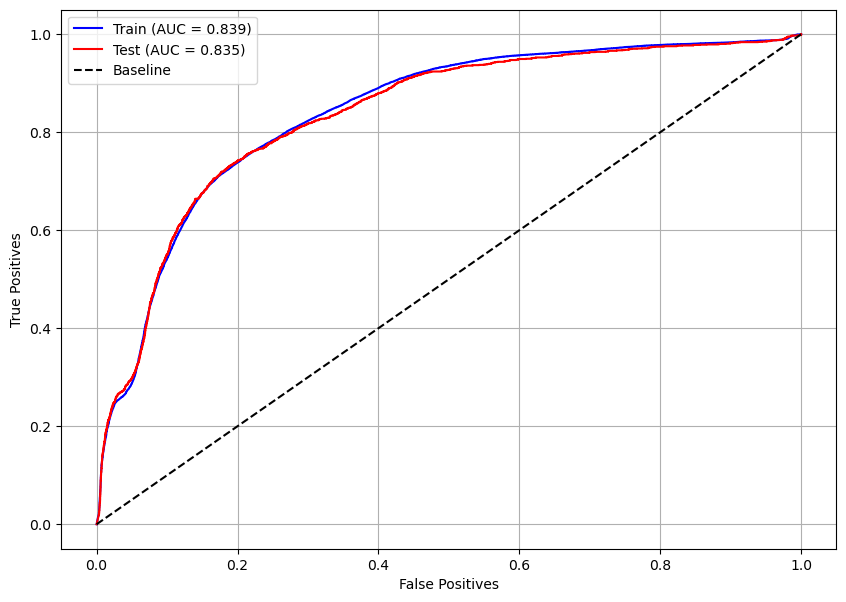

In [24]:
# Curva ROC
plot_roc_curve(nb, X_train, X_test, y_train, y_test)

- Pelas curvas ROC, pode-se dizer que não há overfitting, mas o modelo é ruim para a previsão da classe 1, portanto não seguiremos com análises, neste caso, com este modelo.

### **Random Forest**

O modelo Random Forest é mais complexo em relação ao Naive Bayes, assim alguns hiperparâmetros serão definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

-   `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável  `seed`.
    
-   `max_depth`: será definido como 8, pois o padrão do modelo é não ter profundidade máxima para as árvores, o que dificulta e faz o treinamento ser muito longo, além da maior chance de overfitting.
    
-   `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo, util no caso de classes desbalanceadas, aqui elas foram balanceadas previamente então vamos usar None

In [200]:
class_weights = {0: 0.82, 1: 1}  


rf = RandomForestClassifier(random_state=seed, 
                            class_weight=class_weights,
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 0.82, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

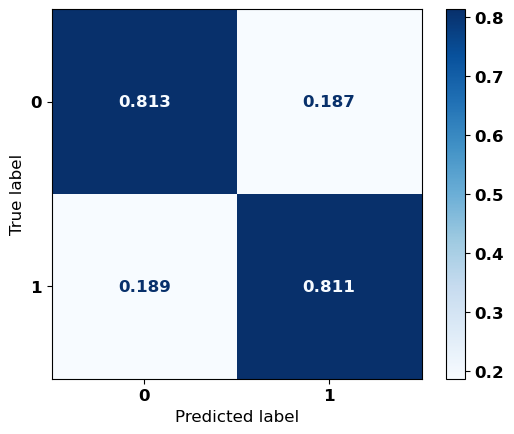


              precision    recall  f1-score   support

           0      0.965     0.813     0.882     12301
           1      0.403     0.811     0.539      1918

    accuracy                          0.813     14219
   macro avg      0.684     0.812     0.711     14219
weighted avg      0.889     0.813     0.836     14219



In [201]:
# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

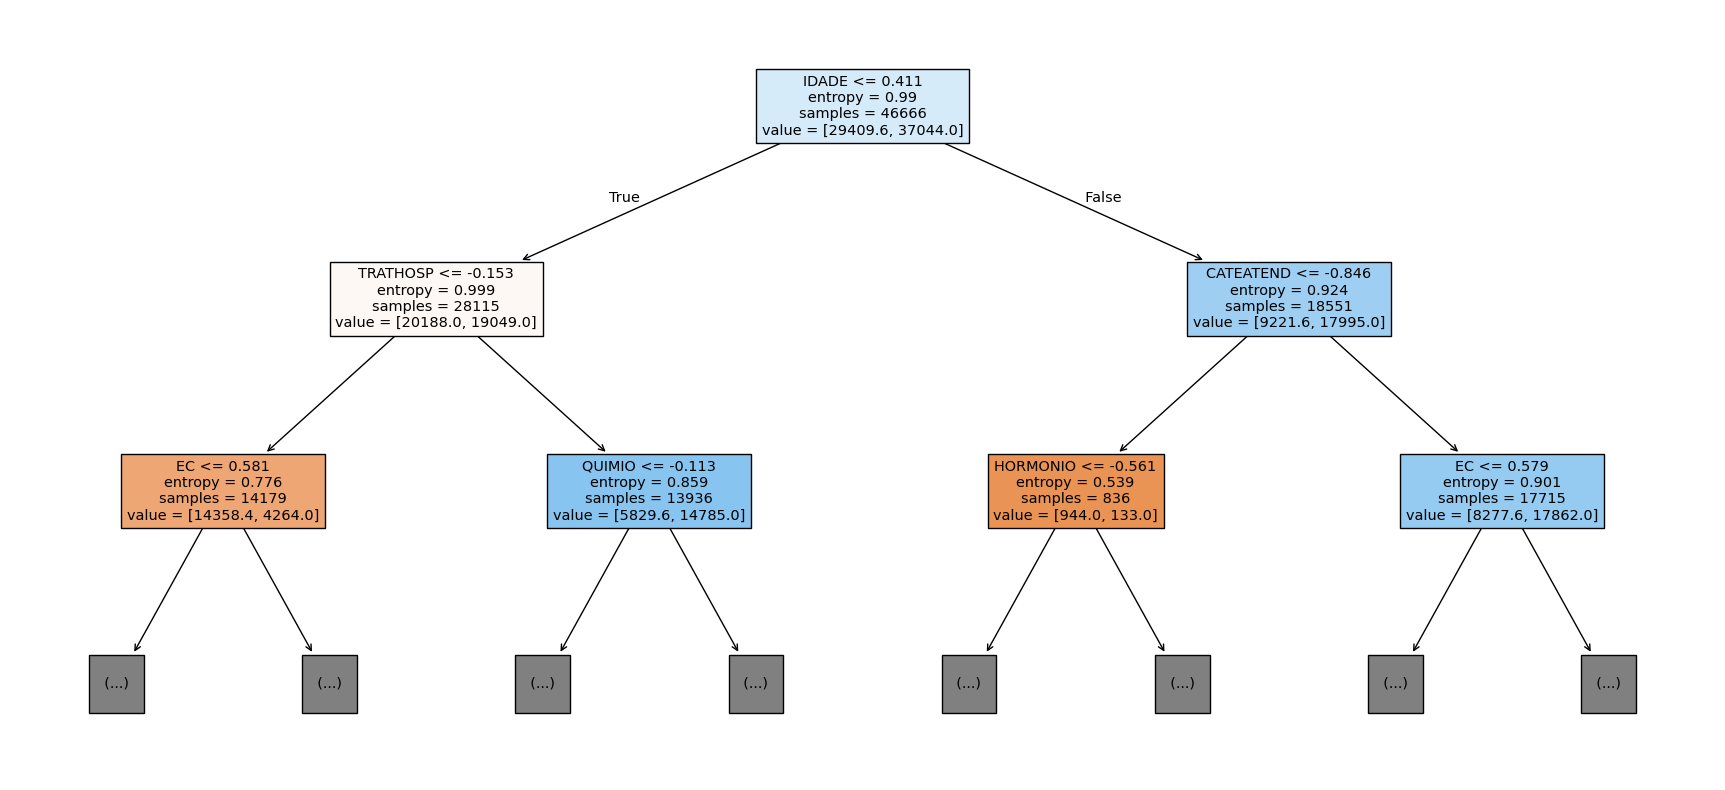

In [29]:
show_tree(rf, feat_cols, 2)

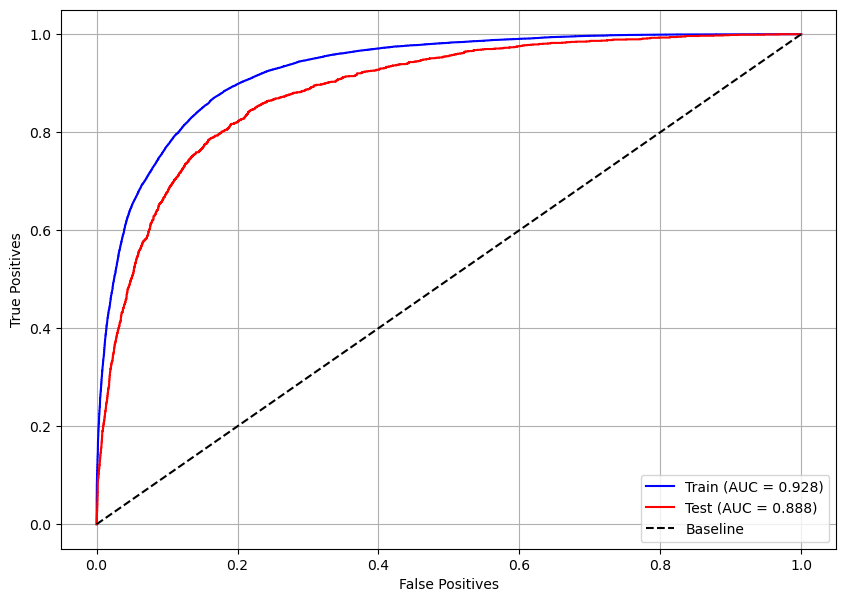

In [30]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

In [32]:
def plot_feat_importances(model, feat_cols, n=10):
    feat_import = pd.Series(model.feature_importances_, index=feat_cols)
    feat_import.nlargest(n).plot(kind='barh', figsize=(10, 8))
    plt.show()

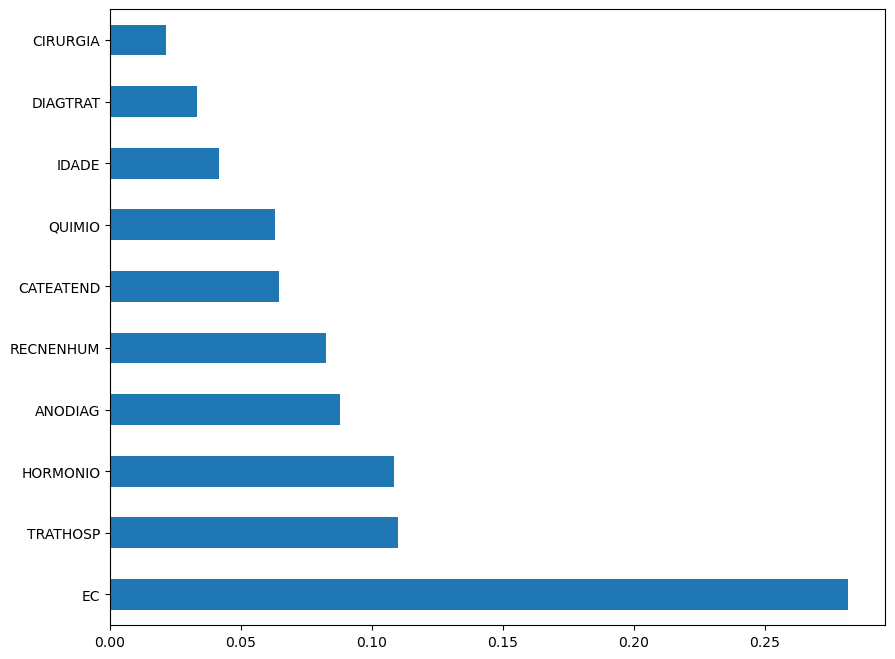

In [33]:
plot_feat_importances(rf, feat_cols)


> As features mais importantes nesta visualização são  `EC`, com uma grande vantagem,  `IDADE`,  `ANODIAG`  e  `CIRURGIA`.

### **XGBoost**

O modelo XGBoost também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

-   `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável  `seed`.
    
-   `max_depth`: será utilizado o padrão, com valor 3.
    
-   `scale_pos_weight`: usado para definir o peso da classe 1 no treinamento do modelo, pois temos classes desbalanceadas.

In [363]:
# Criação e treinamento do modelo XGBoost 
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=3.05,
                    random_state=seed)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=10, ...)

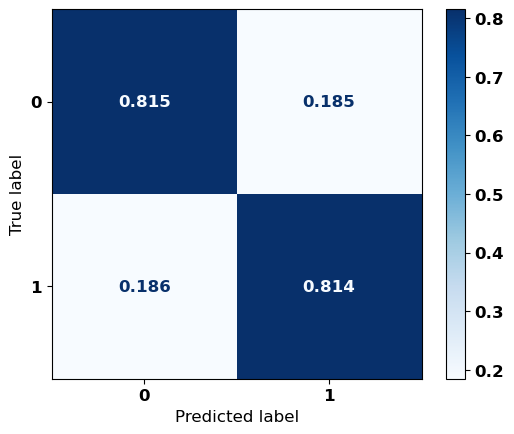


              precision    recall  f1-score   support

           0      0.966     0.815     0.884     12301
           1      0.407     0.814     0.543      1918

    accuracy                          0.815     14219
   macro avg      0.686     0.815     0.713     14219
weighted avg      0.890     0.815     0.838     14219



In [365]:
# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

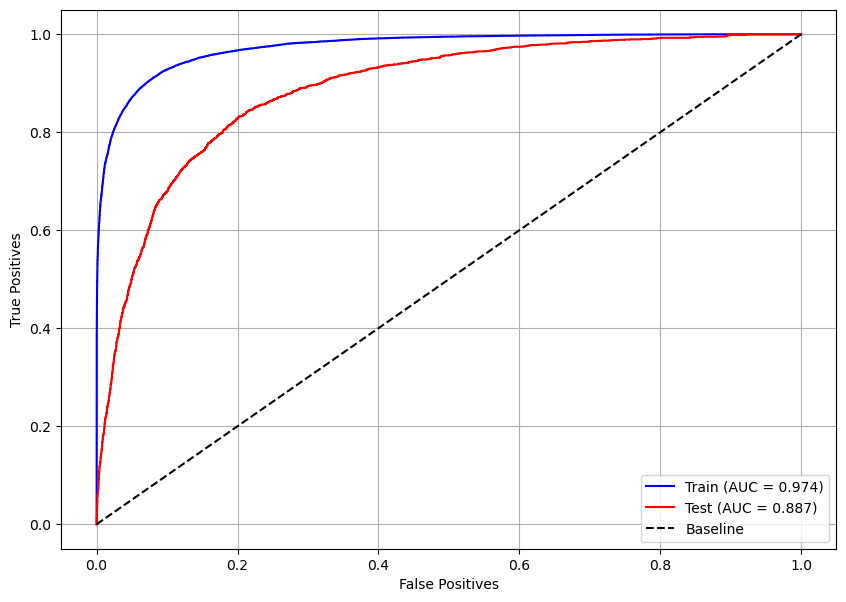

In [52]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

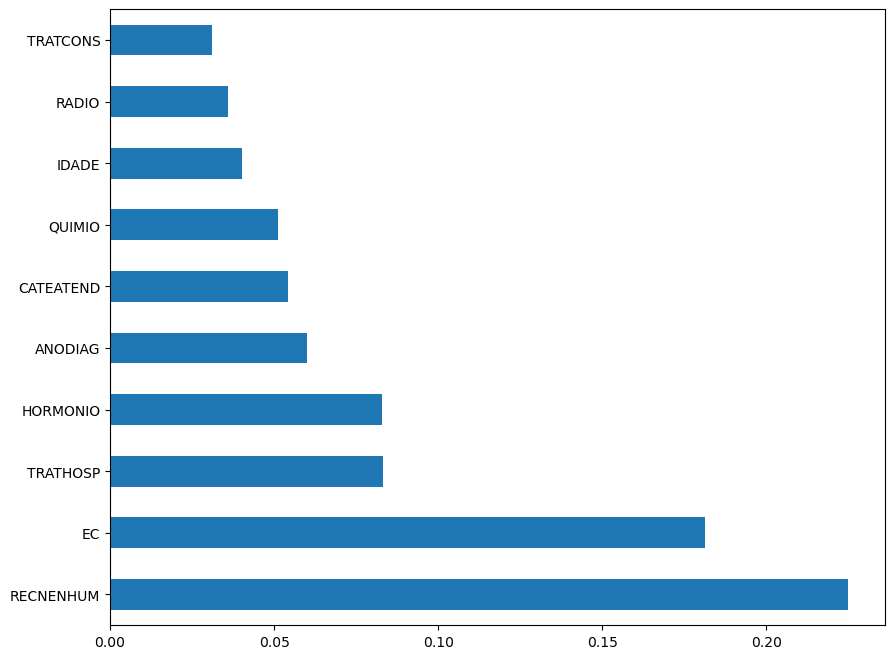

In [53]:
# Importância das features
plot_feat_importances(xgb, feat_cols)

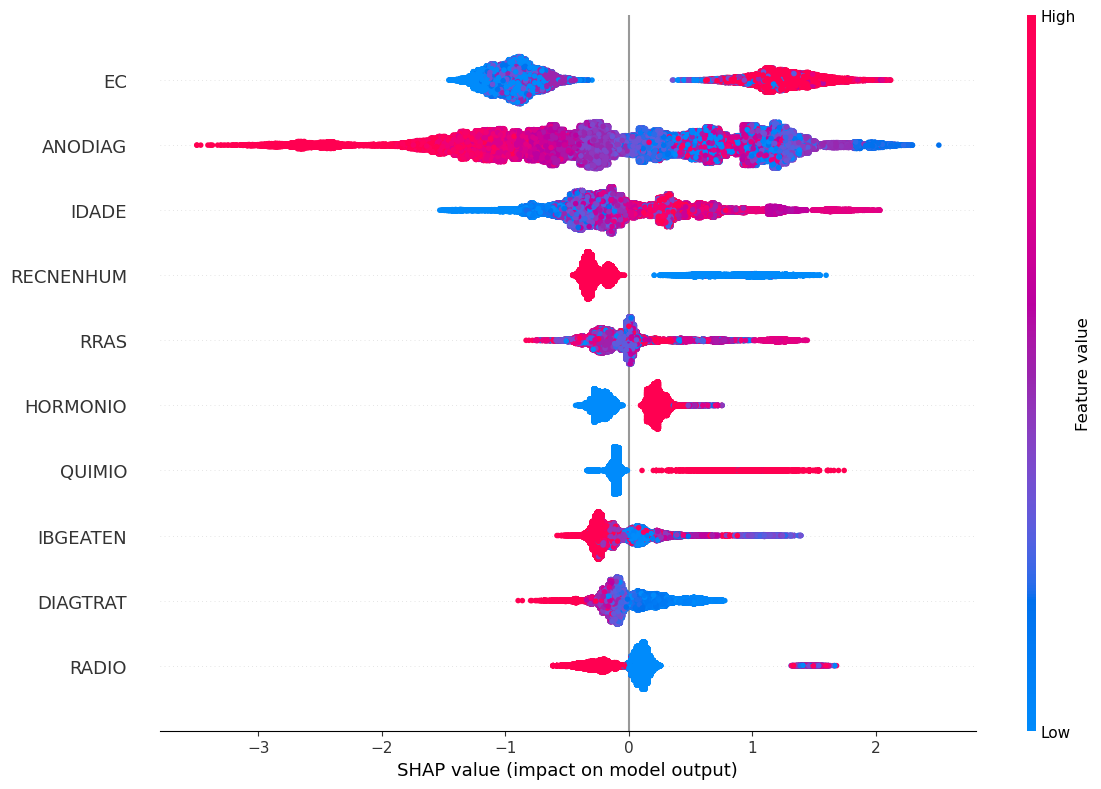

In [54]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)